In [ ]:
!pip install graphviz

# Backpropagation and computation graph

The objective of the current exercise is to introduce how works a deep-learning library. To this end we will devellop in this exercise a python library that build a computational using only scalar operations (consequently it is not yet necessary to use numpy library).

The main object we will manipulate will be the ComputationalGraphNode, this object (or class in python) will have different methods and attributes (discuted during the lecture session). 
We will consider two type of nodes, a classical nodes and parameters node (that will sum the gradient at each backward step).


**Below a code for printing the graphs ! Do not modify the code** 


In [1]:
import graphviz
name_operation_list = {'Addition': '+', 'Multiplication': '*', 'Substraction': '-'}
def createbackwardgraph(root, parent_index=None, graph=None, nodelist={}, edge_list=set()):
    if graph is None:
        graph = graphviz.Digraph(filename = "digraph.gv")
    
    if root not in nodelist:
        nodelist[root] = str(len(nodelist))

        node_name = root.name if 'name' in root.__dict__ else "unknow"
        if root.gradient_function is not None:
            node_name = root.gradient_function.__qualname__.split(".")[0] + " : " + node_name
        node_name += f'\n v = {root.value} \n g = {root.cumulative_gradient}' 

        parent_index = nodelist[root]
        graph.node(parent_index, node_name)


    if root.previous_node_list is None:
        return

    for node in root.previous_node_list:

        if node not in nodelist:
            nodelist[node] = str(len(nodelist))

            node_name = node.name if 'name' in node.__dict__ else "unknow"
            if node.gradient_function is not None:
                node_name = node.gradient_function.__qualname__.split(".")[0] + " : " + node_name
            node_name += f'\n v = {node.value} \n g = {node.cumulative_gradient}' 

            node_index = nodelist[node]
            graph.node(node_index, node_name)
        if not (nodelist[node], nodelist[root]) in edge_list:
            edge_list.add((nodelist[node], nodelist[root]))
            graph.edge(nodelist[node], nodelist[root])
        elif root.previous_node_list[0] ==  root.previous_node_list[-1]: 
            graph.edge(nodelist[node], nodelist[root])
        createbackwardgraph(node, None, graph=graph, nodelist=nodelist, edge_list=edge_list)
    return graph


## Implement the computational graph node

A node of the computation graph needs to store different information :
* A backward operation (computing gradient of the model according to its input)
* The value of the node (a float)
* The gradient of the node (updated/accumulated when backward is called)
* The list of previous nodes (input that produced the current node)

In [2]:
from typing import List, Tuple

class ComputationGraphNode(object):
    def __init__(self, value : float, gradient_function = None , previous_node_list: List = None, name=None):
        if name is not None:
            self.name = name
        self.value = value
        self.cumulative_gradient = .0
        self.gradient_function = gradient_function
        self.previous_node_list = previous_node_list if previous_node_list is not None else [] # Ensure it's a list

    def __str__(self) -> str:
        return f'ComputationGraphNode with value = {self.value}'
    def __repr__(self) -> str :
        return f'ComputationGraphNode with value = {self.value}'
    
    def backward(self, gradient : float = 1.) -> None:
        self.cumulative_gradient += gradient

        if self.gradient_function is not None and self.previous_node_list:
            input_gradients = self.gradient_function(*self.previous_node_list, gradient)

            if not isinstance(input_gradients, (tuple, list)):
                 input_gradients = (input_gradients,)

            if len(input_gradients) != len(self.previous_node_list):
                 raise ValueError(f"Number of gradients ({len(input_gradients)}) does not match number of previous nodes ({len(self.previous_node_list)}) for function {self.gradient_function}")

            for prev_node, input_grad in zip(self.previous_node_list, input_gradients):
                 prev_node.backward(input_grad)

class Parameter(ComputationGraphNode):
    def backward(self, gradient=1) -> float:
        self.cumulative_gradient += gradient

## implement add, mul, sub and relu operations

For each operations we should define a forward function and a gradient_function function. To ease the implementation we will consider an operation as an object that:
* In the method forward takes previous nodes and compute the net node
* In backward methods takes previous input nodes and compute the gradient for each input node


Implement the methods of the following operations :

In [3]:
import math

class Operation(object):
    @staticmethod
    def forward(*args, **kwargs) -> ComputationGraphNode:
        raise NotImplementedError("This is an abstract class, you should inherit from the class")
    @staticmethod
    def gradient_function(*args, **kwargs) -> Tuple[float, ...]:
        raise NotImplementedError("This is an abstract class, you should inherit from the class")

class Addition(object):
    @staticmethod
    def gradient_function(node_a: ComputationGraphNode, node_b: ComputationGraphNode, output_grad: float) -> Tuple[float, float]:
        # d(a+b)/da = 1, d(a+b)/db = 1
        grad_a = output_grad * 1
        grad_b = output_grad * 1
        return grad_a, grad_b

    @staticmethod
    def forward(node_a: ComputationGraphNode, node_b: ComputationGraphNode) -> ComputationGraphNode:
        if not isinstance(node_a, ComputationGraphNode): node_a = ComputationGraphNode(node_a)
        if not isinstance(node_b, ComputationGraphNode): node_b = ComputationGraphNode(node_b)

        value = node_a.value + node_b.value
        return ComputationGraphNode(value, Addition.gradient_function, [node_a, node_b])

class Substraction(object):
    @staticmethod
    def gradient_function(node_a: ComputationGraphNode, node_b: ComputationGraphNode, output_grad: float) -> Tuple[float, float]:
        grad_a = output_grad * 1
        grad_b = output_grad * -1
        return grad_a, grad_b

    @staticmethod
    def forward(node_a: ComputationGraphNode, node_b: ComputationGraphNode) -> ComputationGraphNode:
        if not isinstance(node_a, ComputationGraphNode): node_a = ComputationGraphNode(node_a)
        if not isinstance(node_b, ComputationGraphNode): node_b = ComputationGraphNode(node_b)

        value = node_a.value - node_b.value
        return ComputationGraphNode(value, Substraction.gradient_function, [node_a, node_b])


class Multiplication(object):
    @staticmethod
    def gradient_function(node_a: ComputationGraphNode, node_b: ComputationGraphNode, output_grad: float) -> Tuple[float, float]:
        grad_a = output_grad * node_b.value
        grad_b = output_grad * node_a.value
        return grad_a, grad_b

    @staticmethod
    def forward(node_a: ComputationGraphNode, node_b: ComputationGraphNode) -> ComputationGraphNode:

        if not isinstance(node_a, ComputationGraphNode): node_a = ComputationGraphNode(node_a)
        if not isinstance(node_b, ComputationGraphNode): node_b = ComputationGraphNode(node_b)

        value = node_a.value * node_b.value
        return ComputationGraphNode(value, Multiplication.gradient_function, [node_a, node_b])

class ReLU(object):
    @staticmethod
    def gradient_function(node_a: ComputationGraphNode, output_grad: float) -> Tuple[float]:
        grad_a = output_grad * (1.0 if node_a.value > 0 else 0.0)
        return (grad_a,)
    @staticmethod
    def forward(node_a: ComputationGraphNode) -> ComputationGraphNode:
        if not isinstance(node_a, ComputationGraphNode): node_a = ComputationGraphNode(node_a) # Ensure input is a node
        value = max(0.0, node_a.value)
        return ComputationGraphNode(value, ReLU.gradient_function, [node_a])
    
class Sigmoid(object):
    @staticmethod
    def gradient_function(node_a: ComputationGraphNode, output_grad: float) -> Tuple[float]:
        s = 1 / (1 + math.exp(-node_a.value))
        grad_a = output_grad * s * (1 - s)
        return (grad_a,)

    @staticmethod
    def forward(node_a: ComputationGraphNode) -> ComputationGraphNode:
        if not isinstance(node_a, ComputationGraphNode): node_a = ComputationGraphNode(node_a) # Ensure input is a node
        value = 1 / (1 + math.exp(-node_a.value))
        return ComputationGraphNode(value, Sigmoid.gradient_function, [node_a])

In [4]:
ComputationGraphNode.__add__ = Addition.forward
ComputationGraphNode.__sub__ = Substraction.forward
ComputationGraphNode.__mul__ = Multiplication.forward

**Code/propose different examples and verify that when calling backward on the last node you obtain the correct gradient !!**


NB : You can use createbackwardgraph(loss) to show the computation graph and values

Example 1: ComputationGraphNode with value = 5.0 + ComputationGraphNode with value = 3.0 = ComputationGraphNode with value = 8.0
  Grad a: 1.0
  Grad b: 1.0


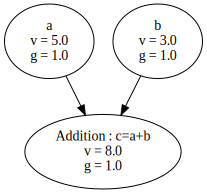

In [5]:
a = ComputationGraphNode(5.0, name='a')
b = ComputationGraphNode(3.0, name='b')
c = a + b
c.name = 'c=a+b'
print(f"Example 1: {a} + {b} = {c}")
c.backward(1.0)
print(f"  Grad a: {a.cumulative_gradient}") # expected: 1.0
print(f"  Grad b: {b.cumulative_gradient}") # expected: 1.0
graph = createbackwardgraph(c)
graph

## Create a module that apply linear transformation

We consider now a new class namely Module, all the module you will implement will inherit from this class. Notice also that module may have parameters (node of type `Parameter`) that will be returned calling `my_module.parameter`


In [6]:
class Module:
    def __init__(self):
        pass
        
    def parameters(self):
        ret = []
        for name in dir(self):
            o = self.__getattribute__(name)

            if type(o) is Parameter:
                ret.append(o)
            if isinstance(o, Module) or isinstance(o, ModuleList):
                ret.extend(o.parameters())
        return ret

class ModuleList(list):
    def parameters(self):
        ret = []
        for m in self:
            if type(m) is Parameter:
                ret.append(m)
            elif isinstance(m, Module) or isinstance(m, ModuleList):
                ret.extend(m.parameters())
        return ret

Implement the two modules :

* Linear which apply on a list of node a linear transformation with bias $Wx^t + b$
* The relu function that compute from a list the relu for each element

In [7]:
import random

class Linear(Module):
    def __init__(self, input_size, output_size, bias=True):
        super().__init__() # Call parent init
        self.input_size = input_size
        self.output_size = output_size
        self.weights = ModuleList([ModuleList([Parameter(random.uniform(-0.5, 0.5), name=f'w_{j}_{i}') for i in range(input_size)]) for j in range(output_size)])
        
        if bias:
            self.bias = ModuleList([Parameter(0.01, name=f'b_{j}') for j in range(output_size)])
        else:
            self.bias = None

    def __call__(self, node_list : List[ComputationGraphNode]) -> List[ComputationGraphNode]:
        if len(node_list) != self.input_size:
            raise ValueError(f"Input size mismatch: expected {self.input_size}, got {len(node_list)}")

        output_nodes = []
        for j in range(self.output_size):
            dot_product = ComputationGraphNode(0.0)
            for i in range(self.input_size):
                 dot_product += node_list[i] * self.weights[j][i]

            if self.bias is not None:
                 output_node = dot_product + self.bias[j]
                 output_node.name = f'linear_{j}_out'
                 output_nodes.append(output_node)
            else:
                 dot_product.name = f'linear_{j}_out'
                 output_nodes.append(dot_product)

        return output_nodes

    def __repr__(self):
        return f"Linear(input_size={self.input_size}, output_size={self.output_size}, bias={self.bias is not None})"

def relu(x_list : List[ComputationGraphNode]) -> List[ComputationGraphNode]:
    return [ReLU.forward(x) for x in x_list]

def sigmoid(x_list : List[ComputationGraphNode]) -> List[ComputationGraphNode]:
    return [Sigmoid.forward(x) for x in x_list]

l = Linear(2, 3)
l([Parameter(0), Parameter(1)])

[ComputationGraphNode with value = 0.140517934545202,
 ComputationGraphNode with value = -0.285966978167987,
 ComputationGraphNode with value = -0.16597179046910782]

In [8]:
l.parameters()

[ComputationGraphNode with value = 0.01,
 ComputationGraphNode with value = 0.01,
 ComputationGraphNode with value = 0.01,
 ComputationGraphNode with value = -0.3351167121233094,
 ComputationGraphNode with value = 0.130517934545202,
 ComputationGraphNode with value = 0.29064338607366125,
 ComputationGraphNode with value = -0.295966978167987,
 ComputationGraphNode with value = -0.1352913510289412,
 ComputationGraphNode with value = -0.17597179046910782]

## Create your network similarly
Create a two layer networks with as activation a sigmoid function :
* input_size being the size of the input X
* intermediate_size the hidden layer size
* output_size the size of the outpu (for binary classification it is 1)


In [9]:
class MyTwoLayerNetwork(Module):
    def __init__(self, input_size, intermediate_size, output_size = 1):
        super().__init__()
        self.layer1 = Linear(input_size, intermediate_size)
        self.activation1 = sigmoid
        self.layer2 = Linear(intermediate_size, output_size)

    def __call__(self, node_list : List[ComputationGraphNode]) -> List[ComputationGraphNode]:
        x = self.layer1(node_list)
        x = self.activation1(x)
        x = self.layer2(x)
        return x

    def __repr__(self):
        return f"MyTwoLayerNetwork(\n  {self.layer1},\n  {self.activation1.__name__},\n  {self.layer2}\n)"

### Implement the following functions :
* hing_loss computing the hinge loss from node
* update_weight that will update all the weights given in parameters $\theta^t = \theta^{t-1}  - \lambda \nabla_{\theta^{t-1}} L$
* zero_grad that set all accumulated gradient of the nodes to 0

In [10]:
## Create your loss function

def hinge_loss(x : ComputationGraphNode, y: ComputationGraphNode):
    return  ReLU.forward(ComputationGraphNode(1) - x * y)

def update_weight(parameter_list : List[ComputationGraphNode], learning_rate: float) -> None:
    lr = float(learning_rate)
    for node in parameter_list:
        if isinstance(node, Parameter):
             if isinstance(node.cumulative_gradient, (int, float)):
                node.value -= lr * node.cumulative_gradient
             else:
                 print(f"Warning: Non-numeric gradient {node.cumulative_gradient} found for parameter {getattr(node, 'name', 'unnamed')}. Skipping update.")

def zero_grad(parameter_list: List[ComputationGraphNode]) -> None:
    for node in parameter_list:
        if isinstance(node, Parameter):
             node.cumulative_gradient = 0.0

## Build a network that can solve the following problem

Train your network on the following dataset and provide accuracy of the model on the training data (only for this example else consider separated trianing and testing set)

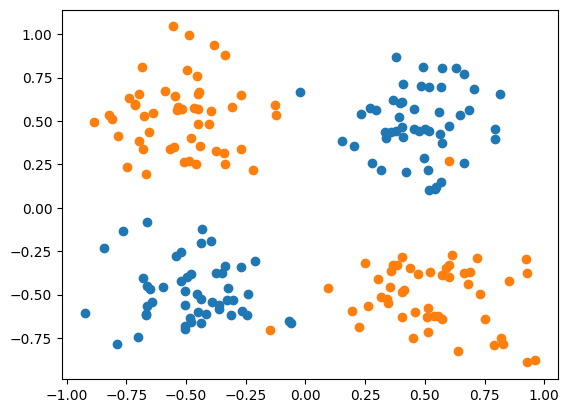

In [11]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
dataset = list(zip(np.random.randn(50,2)*0.2 + [0.5, 0.5], np.ones(50))) \
               + list(zip(np.random.randn(50,2)*0.2 + [-0.5, 0.5], np.zeros(50)))\
               + list(zip(np.random.randn(50,2)*0.2 + [0.5, -0.5], np.zeros(50))) \
               +  list(zip(np.random.randn(50,2)*0.2 + [-0.5, -0.5], np.ones(50)))
X, Y = np.array([x for (x, _) in dataset]), np.array([y for (_, y) in dataset]) 

plt.scatter(X[Y==1][:, 0],X[Y==1][:, 1])
plt.scatter(X[Y==0][:, 0],X[Y==0][:, 1])

In [12]:
model = MyTwoLayerNetwork(2, 4, 1)

In [13]:
n_epoch = 30
w = [0.1, 0.1]
b = 0.1
learning_rate = 0.1
parameter_list = model.parameters()
for epoch in range(n_epoch):
    loss_values = []
    shuffled_index = np.arange(len(X))
    np.random.shuffle(shuffled_index)

    for i in shuffled_index:
        x, y_true_01 = X[i], Y[i]

        input_nodes = [ComputationGraphNode(val, name=f'x{j}_{i}') for j, val in enumerate(x)]

        y_target_pm1 = 2 * y_true_01 - 1
        target_node = ComputationGraphNode(y_target_pm1, name=f'y_{i}')

        pred_nodes = model(input_nodes)
        pred = pred_nodes[0]

        loss = hinge_loss(pred, target_node)

        zero_grad(parameter_list)
        loss.backward()
        loss_values.append(loss.value)

        update_weight(parameter_list, learning_rate)

        zero_grad(parameter_list)

    #print(pred)
    print(f'The loss for the epoch {epoch} is {np.mean(loss_values)}')
    loss_values = []

The loss for the epoch 0 is 1.005705354014964
The loss for the epoch 1 is 1.0660091262008513
The loss for the epoch 2 is 1.011480301844298
The loss for the epoch 3 is 1.0841052019777797
The loss for the epoch 4 is 1.0713726208430108
The loss for the epoch 5 is 0.9841945426842144
The loss for the epoch 6 is 1.0562595200532097
The loss for the epoch 7 is 1.073658287713771
The loss for the epoch 8 is 1.0671068530748276
The loss for the epoch 9 is 1.0140412535560612
The loss for the epoch 10 is 1.060434664645072
The loss for the epoch 11 is 1.0222573791327358
The loss for the epoch 12 is 1.043176013275342
The loss for the epoch 13 is 1.0152130579739795
The loss for the epoch 14 is 1.0622545650074
The loss for the epoch 15 is 0.9882323582049091
The loss for the epoch 16 is 1.0297137353443415
The loss for the epoch 17 is 1.021087570284409
The loss for the epoch 18 is 1.056846373083298
The loss for the epoch 19 is 1.0009917843995337
The loss for the epoch 20 is 1.0487886527696597
The loss for

### Evaluate accuracy

In [14]:
# test 
score = 0
for i in shuffled_index:
    x, y = X[i], Y[i]
    pred = model([ComputationGraphNode(x_val) for x_val in x])
    score += 1 if (pred[0].value *  (2 * y - 1)  > 0) else  0
score/len( X)

0.985